# Multi-SWAG

## Introduction

In this notebook, we will illustrate how to use Push to apply **Stochastic Weight Averaging Gaussian** (SWAG) [1] to perform BDL. SWAG approximates the posterior distribution of a BNN as a Normal distribution with mean and covariance estimated from gradient descent iterates during traditional training.

### Setting up the Dataset

We will utilize the [toy](https://lbai-push.readthedocs.io/en/latest/examples/03_Datasets/toy.html) regression dataset to train our model.

In [1]:
# Set a seed for reproducibility
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])

dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

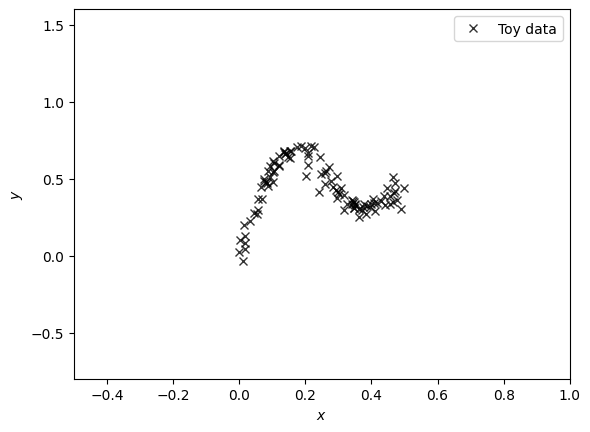

In [2]:
import matplotlib.pyplot as plt

# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

## Defining the Model

In [3]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

## SWAG in Push

We will use the implementation of SWAG provided by PusH. To apply SWAG, we first create a `MultiSWAG` object. **MultiSWAG** is an extension of SWAG to multiple particles which we will discuss soon.

In [4]:
import push.bayes.swag
from push.bayes.swag import MultiSWAG

lr = 0.03
args = [
    1,    # number of input dimensions
]
mswag = MultiSWAG(GenericNet, *args)

### Performing Bayesian Inference

The `MultiSWAG` class contains a `bayes_infer` method that we can use to perform Bayesian inference. At a high-level, the algorithm works as follows:
1. Train a given NN using a standard optimization method for a certain number of epochs (`pretrain_epochs`).
2. Continue to train a given NN using a standard optimization method, this time, keeping track of the first and second moments of the parameters at each gradient descent iterate (`swag_epochs`). The first and second moment information is used later on to estimate the mean and covariance of the Gaussian distribution used to approximate the posterior distribution.

In [5]:
import torch
from torch.utils.data import DataLoader



#  Perform bayesian inference with SWAG
mswag.bayes_infer(
    train_loader,
    pretrain_epochs=2000,
    swag_epochs=1000,
    cov_mat_rank=20,
    num_models=1,
    lr = lr
)

100%|██████████| 1000/1000 [00:10<00:00, 98.78it/s, loss=tensor(0.0025)]


### Multiple SWAG (MultiSWAG)

Intuitively, SWAG performs averaging within a single basin of attraction since the NN is optimized for `pretrain_epochs` before using `swag_epochs` number of gradient descent iterates to estimate the mean and covariance of a Gaussian distribution which is unimodal. SWAG can be extended to Multiple SWAG (MultiSWAG) [2], similar to deep ensembles, which allows for averaging over multiple basins of attraction. We can use the capabilities of Push to easily extend SWAG to MultiSWAG by simply changing `num_models` to increase the number of particles contained within an instance of `MultiSWAG`.

#### Training Two SWAG Models

The `push.bayes.swag` provides a `train_mswag` function that creates a `MultiSWAG` instance and calls `bayes_infer` to perform Bayesian inference.

In [6]:
# 1. Training parameters
swag_epochs = 1000
pretrain_epochs = 2000
cov_mat_rank = 20
loss_fn = torch.nn.MSELoss()

# 2. Perform MultiSWAG
sixteen_particle_mswag = push.bayes.swag.train_mswag(
    train_loader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    GenericNet, *args,      # NN template
    num_devices=2,        # Set the number of devices to 2 for faster training
    num_models=16,         # 16 SWAG instances
    cov_mat_rank=20,      # Rank of covariance matrix (used during posterior predictive inference)
    lr = lr,              # Learning rate
    mswag_state = {}
)

100%|██████████| 1000/1000 [01:37<00:00, 10.21it/s, loss=tensor(0.0025)]


#### Training four and eight SWAG instances

Just like we did with deep ensembles, we can increase the number of particles. In this example, we choose 4 and 8 SWAG instances. Note that Push handles the scaling of particles across multi-GPU devices. MultiSWAG, like deep ensembles, does not require communication between SWAG instances as a more advanced BDL algorithm might require such as Stein Variational Gradient Descent (SVGD). As a reminder, each SWAG particle has concurrent execution semantics so it can execute independently of other SWAG instances. 

In [7]:
thirtytwo_particle_mswag = push.bayes.swag.train_mswag(
    train_loader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    GenericNet, *args,    # NN template
    num_devices=2,      # Set the number of devices to 2 for faster training
    num_models=32,       # 32 SWAG instances
    cov_mat_rank=20,    # Rank of covariance matrix (used during posterior predictive inference)   
    lr=lr,              # Learning rate
    mswag_state={},
)

sixtyfour_particle_mswag = push.bayes.swag.train_mswag(
    train_loader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    GenericNet, *args,    # NN template
    num_devices=2,      # Set the number of devices to 2 for faster training
    num_models=64,       # 64 SWAG instances
    cov_mat_rank = 20,  # Rank of covariance matrix (used during posterior predictive inference)
    lr=lr,              # Learning rate
    mswag_state={},
)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s, loss=tensor(0.0025)]


## Posterior Predictive Inference

Now that we have successfully trained a few models with MultiSWAG, we can make predictions with the model.

### Making Predictions from the Posterior Predictive Distribution

After training (i.e., calling `bayes_infer`), the instance of `MultiSWAG` contains the **posterior predictive** distribution. In the case of MultiSWAG, the posterior predictive distribution is approximated as a mixture of Gaussians. To make predictions using the posterior predictive distribution, we can use the `posterior_pred` method. The `posterior_pred` method uses the empirical first and second moments of the gradient descent iterates to estimate the posterior distribution as the following multi-variate Gaussian distribution:

$$
\tilde{\theta} \sim \mathcal{N}(\bar{\theta}, \frac{1}{2} \bar{\theta} (\Sigma_\text{diag} + \Sigma_{\text{low-rank}}))
$$

1. $\bar{\theta}$ is the empirical first moment calculated during training.
2. $\bar{\theta^2}$ is the empirical second moment calculated during training.
3. $\Sigma_\text{diag} = \text{diag}(\bar{\theta^2} - \bar{\theta}^2)$ are derived from the empirical first and second moments calculated during training.
4. $\hat{D}$ is a quantity derived from the empirical first and second moments calculated during training.
    - $D$ is a matrix with columns $D_i = (\theta_i − \bar{\theta}_i)$ is a column vector where $\theta_i$ is the $i$-th parameter estimate and $\bar{\theta}_i$ is the running estimate of the parameter's mean obtained from the first $i$-samples.
    - $\hat{D}$ is the matrix that contains the last $K$ columns of $D$.
    - $\Sigma_{\text{low-rank}} = \frac{1}{K-1} \hat{D}\hat{D}^T$ is a low rank approximation of the empirical covariance.

In [8]:
modes = ["mean", "std", "pred"]
# one_particle_outputs = mswag.posterior_pred(x_grid, loss_fn, num_samples=20, mode=modes, f_reg=True)
sixteen_particle_outputs = sixteen_particle_mswag.posterior_pred(x_grid, loss_fn, num_samples=20, mode=modes, f_reg=True)
thirtytwo_particle_outputs = thirtytwo_particle_mswag.posterior_pred(x_grid, loss_fn, num_samples=20, mode=modes, f_reg=True)
sixtyfour_particle_outputs = sixtyfour_particle_mswag.posterior_pred(x_grid, loss_fn, num_samples=20, mode=modes, f_reg=True)

#### Plotting our results

We can use the following helper function to help us visualize the range of predictions made by MultiSWAG.

In [9]:
import matplotlib.pyplot as plt
def plot_toy(outputs, num_models, title):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])

    # Plot predictive mean and std (left graph)
    axs[0].plot(X, Y, "kx", label="Toy data", markersize=1)
    axs[0].set_xlim(-0.5, 1)
    axs[0].set_ylim(-2, 2)
    axs[0].plot(x_grid, outputs["mean"], "r--", linewidth=1)
    axs[0].fill_between(x_grid.reshape(1, -1)[0], (outputs["mean"] - outputs["std"]).squeeze(), (outputs["mean"] + outputs["std"]).squeeze(), alpha=0.5, color="red")
    axs[0].fill_between(
        x_grid.reshape(1, -1)[0], (outputs["mean"] + 2 * outputs["std"]).squeeze(), (outputs["mean"] - 2 * outputs["std"]).squeeze(), alpha=0.2, color="red"
    )
    axs[0].set_title("Predictive Mean and Std")

    # Plot means of each net in ensemble (right graph)
    axs[1].plot(X, Y, "kx", label="Toy data", markersize=1)
    axs[1].set_xlim(-0.5, 1)
    axs[1].set_ylim(-1.5, 2)
    axs[1].set_title("Individual Model output")

    for j in range(num_models):
        axs[1].plot(x_grid, torch.tensor([sublist[j] for sublist in outputs["pred"]]), linestyle="--", linewidth=1)
    fig.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

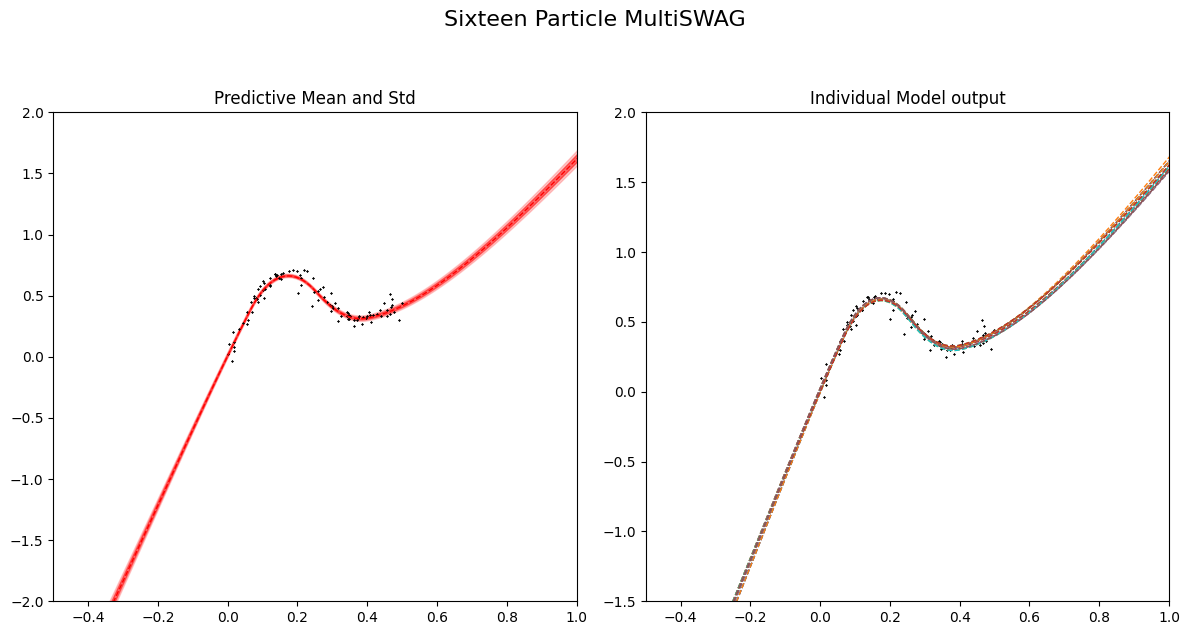

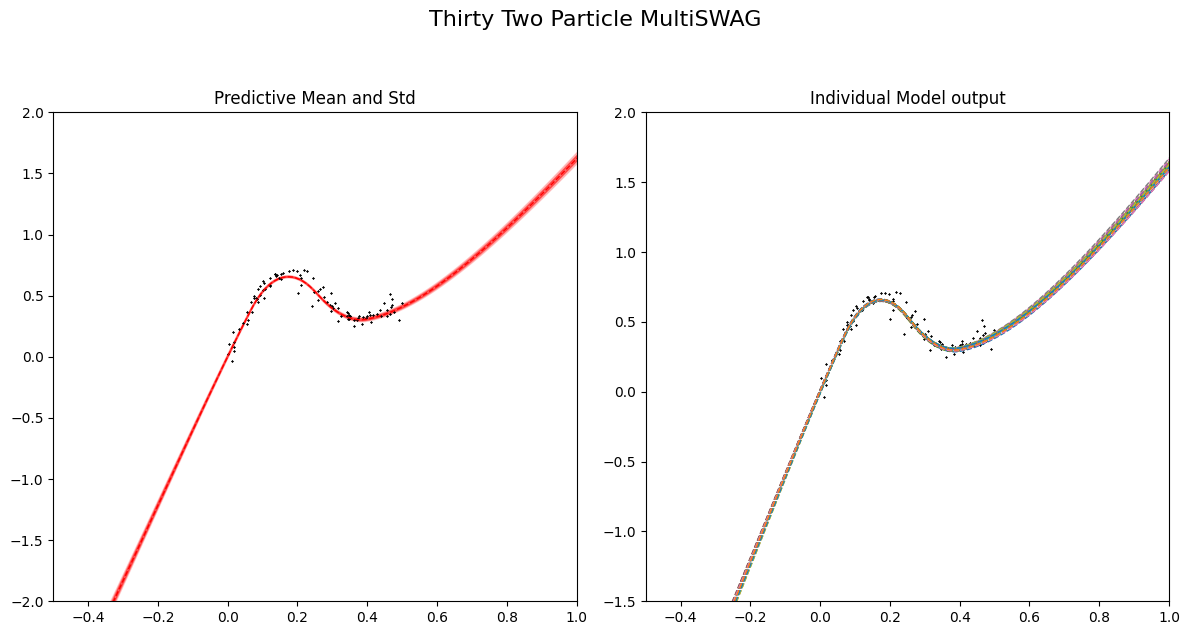

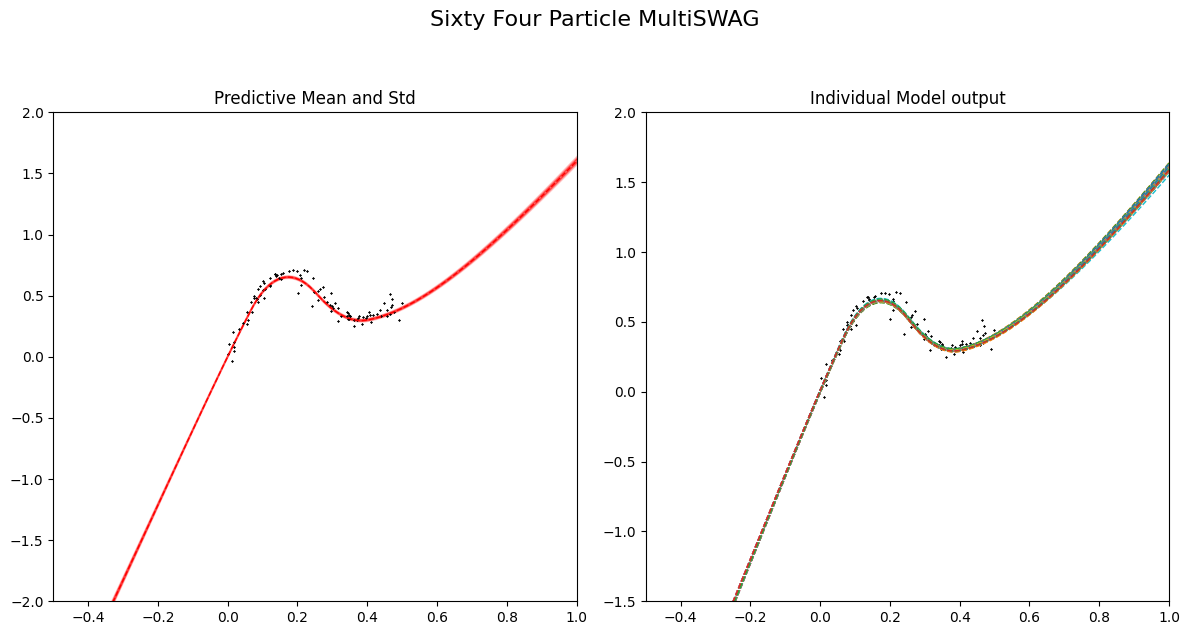

In [11]:
# plot_toy(one_particle_outputs, 1, "One Particle SWAG")
plot_toy(sixteen_particle_outputs, 16, "Sixteen Particle MultiSWAG")
plot_toy(thirtytwo_particle_outputs, 32, "Thirty Two Particle MultiSWAG")
plot_toy(sixtyfour_particle_outputs, 64, "Sixty Four Particle MultiSWAG")

## References

[1] Wesley J. Maddox, Pavel Izmailov, Timur Garipov, Dmitry P. Vetrov, and Andrew Gordon Wilson. A simple baseline for bayesian uncertainty in deep learning. Advances in Neural Information Processing Systems, 32, 2019.

[2] Andrew Gordon Wilson and Pavel Izmailov. Bayesian deep learning and a probabilistic perspective of generalization. In Proceedings of the 34th International Conference on Neural Information Processing Systems, Neurips 2020.